### 2 electrons in a 1D infinites square well potential

In [1]:
import os
import csv
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from qiskit_algorithms import VQE
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA, SLSQP, SPSA
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

In [2]:
optimizer = COBYLA
optimizer_str = 'COBYLA'
L = 1
N = 3

##### Functions

In [3]:
x = sp.Symbol('x')
x_1 = sp.Symbol('x_1')
x_2 = sp.Symbol('x_2')

https://phys.libretexts.org/Bookshelves/Modern_Physics/Book%3A_Spiral_Modern_Physics_(D'Alessandris)/6%3A_The_Schrodinger_Equation/6.2%3A_Solving_the_1D_Infinite_Square_Well

In [4]:
def well_wavefunction(n, L, x = sp.Symbol('x')):
    """
    Calcula la función de onda para un estado dado (n) en un pozo de potencial infinito.
    
    Parámetros:
        n (int): Estado cuántico del electrón.
    
    Retorna:
        La función de onda.
    """
    
    # Factor de normalización
    normalization_factor = sp.sqrt(2/L)
    
    # Función de onda radial
    well_wavefunction = normalization_factor * sp.sin(n*sp.pi*x/L)
    
    return well_wavefunction

https://qiskit-community.github.io/qiskit-nature/stubs/qiskit_nature.second_q.hamiltonians.ElectronicEnergy.html

In [5]:
def hamiltonian_interaction(L, N = 3, v_0 = 1):
    h_pq = []

    for i in range(1, N+1):
        h_pq.append([])
        for j in range(1, N+1):
            globals()[f'h_{i}{j}'] = -1/2 * sp.integrate(globals()[f'phi_{i}']*globals()[f'dd_phi_{j}'], (x, 0, L))
            h_pq[i-1].append(globals()[f'h_{i}{j}'])

    size = len(h_pq)
    h1_a = np.array(h_pq, dtype=float)
    
    h_ijkl = np.zeros((size, size, size, size))

    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(N):
                    globals()[f'h_{i}{j}{k}{l}'] = v_0*\
                                                   globals()[f'phi_{i+1}_1']*globals()[f'phi_{j+1}_2']*\
                                                   globals()[f'phi_{k+1}_2']*globals()[f'phi_{l+1}_1']

                    h_ijkl[i][j][k][l] = sp.integrate(globals()[f'h_{i}{j}{k}{l}'], (x_1, 0, L))

    h2_aa = np.array(h_ijkl, dtype=float)

    hamiltonian = ElectronicEnergy.from_raw_integrals(h1_a, h2_aa)

    return hamiltonian

In [6]:
def save_csv(folder, name, data):
    v_0 = data[0]
    energies = data[1]

    if not os.path.exists(folder):
        os.makedirs(folder)

    nombre_archivo = f'{name}.csv'
    ruta_archivo = os.path.join(folder, nombre_archivo)

    with open(ruta_archivo, mode='w', newline='') as archivo_csv:
        escritor_csv = csv.writer(archivo_csv)
        escritor_csv.writerow(['v_0', 'energy'])
        for x, y in zip(v_0, energies):
            escritor_csv.writerow([x, y])

##### Wavefunction Solutions

In [7]:
n_max = 8

for n in range(1, n_max+1):
    for l in range(n):
        globals()[f'phi_{n}'] = well_wavefunction(n, L)
        globals()[f'dd_phi_{n}'] = sp.diff(globals()[f'phi_{n}'], x, x)

In [8]:
n_max = 8

for n in range(1, n_max+1):
    for l in range(n):
        globals()[f'phi_{n}_1'] = well_wavefunction(n, L, sp.Symbol('x_1'))
        globals()[f'phi_{n}_2'] = well_wavefunction(n, L, sp.Symbol('x_1'))

##### Hamiltonian

Interaction

In [9]:
# hamiltonian_interaction = hamiltonian_interaction(L, 2)
# print(hamiltonian_interaction.electronic_integrals.alpha)

##### VQE

Interaction

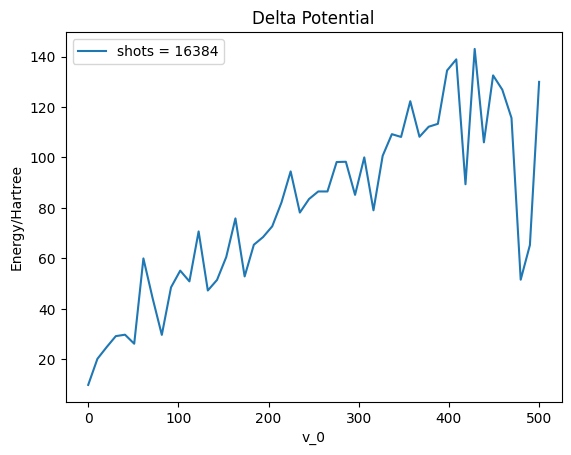

In [10]:
# shots = [16, 128, 1024, 16384]
shots = [16384]
v_0_list = np.linspace(0, 500, 50)

for shot in shots:
        
    energies = []

    for v_0 in v_0_list:
        hamiltonian = hamiltonian_interaction(L, N, v_0)

        mapper = JordanWignerMapper()
        fermionic_op = hamiltonian.second_q_op()
        qubit_op = mapper.map(fermionic_op)

        num_spatial_orbitals = int(fermionic_op.num_spin_orbitals/2)
        # The tuple of the number of alpha- and beta-spin particles
        num_particles = (1, 1)

        ansatz = UCCSD(
            num_spatial_orbitals,
            num_particles,
            mapper,
            initial_state=HartreeFock(
                num_spatial_orbitals,
                num_particles,
                mapper,
            ),
        )

        # seed = 170
        # algorithm_globals.random_seed = seed

        noiseless_estimator = AerEstimator(
            run_options={"shots": shot}
        )

        vqe_solver = VQE(noiseless_estimator, ansatz, optimizer(maxiter=100))
        vqe_solver.initial_point = np.zeros(ansatz.num_parameters)
        
        eigenvalue = vqe_solver.compute_minimum_eigenvalue(operator=qubit_op).eigenvalue
        energies.append(eigenvalue)

    save_csv(f'results_{optimizer_str}_N={N}', f'shots={shot}', [v_0_list, energies])
    plt.plot(v_0_list, energies, marker='', linestyle='-', label=f'shots = {shot}')

plt.xlabel('v_0')
plt.ylabel('Energy/Hartree')
plt.title('Delta Potential')
plt.legend()
plt.savefig(f'results_{optimizer_str}_N={N}/delta_potential')
plt.show()